# Imports

In [3]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
import math
from datetime import datetime
import matplotlib.pyplot as plt
from random import randint

In [41]:
from pprint import pprint
import pandas as pd

# General functions

## Vectorise each document and create 2 lists: 
1. List of vectorised docs with targets
2. List of all unique terms

In [4]:
def vectorise_doc(doc):
    vect = CountVectorizer(stop_words = 'english', strip_accents = 'ascii',) 
    try:
        vect.fit([doc])
        vectorised_doc = vect.get_feature_names()
    except:
        vectorised_doc = []
    vectorised_doc_clean = []
    for term in vectorised_doc:
        term = term.replace('_', '')
        if not term.isdigit():
            if len(term) >= 3:
                vectorised_doc_clean.append(term)
        else:
            vectorised_doc_clean.append(term)
    return vectorised_doc_clean

In [5]:
def vectorised_docs_words_list(documents):
    vectorised_documents = []
    words_list = []
    for doc in documents:
        vectorised_doc = vectorise_doc(doc[0])
        vectorised_documents.append([vectorised_doc, doc[1]])
        for term in vectorised_doc:
            if term not in words_list:
                words_list.append(term)
    return vectorised_documents, words_list

## For each word in train set calculete number of documents

In [6]:
def calculate_documents(vectorised_documents, words_list):
    words_list_count = {}
    for doc in vectorised_documents: 
        for term in words_list:
            if term in doc[0]:
                if term in words_list_count:
                    if doc[1] in words_list_count[term]:
                        words_list_count[term][doc[1]] += 1
                    else:
                        words_list_count[term][doc[1]] = 1
                else:
                    words_list_count[term] = {}
                    words_list_count[term][doc[1]] = 1

    return words_list_count

## Calculate total number of docs for each class

In [7]:
def calculatet_total_docs_count(documents):
    total_docs_count = {}
    for doc in documents:
        if doc[1] in total_docs_count:
            total_docs_count[doc[1]] += 1
        else:
            total_docs_count[doc[1]] = 1
    return total_docs_count

## For each term calculate ABCD

In [8]:
def calculate_a_b_c_d (classes , words_list_count, total_docs_count):
    words_list_abcd = {}
    for p_class in classes: 
        for word in words_list_count: 
            if p_class in words_list_count[word]:
                a = words_list_count[word][p_class]
                word_classes = words_list_count[word]
                
                b = 0
                for item in word_classes:
                    if p_class != item:
                        b += word_classes[item]
                c = total_docs_count[p_class] - a
                d = sum(value for value in total_docs_count.values()) - a - b - c
                if word in words_list_abcd:
                    if p_class in words_list_abcd[word]:
                        words_list_abcd[word][p_class] = [a, b, c, d]
                    else:
                        words_list_abcd[word][p_class] = []
                        words_list_abcd[word][p_class] = [a, b, c, d]
                else:
                    words_list_abcd[word] = {}
                    words_list_abcd[word][p_class] = []
                    words_list_abcd[word][p_class] = [a, b, c, d]
                
                
    return words_list_abcd                

## Build Profiles 

## Define functions for calculation terms weight in profiles

In [9]:
def jaccard (a,b,c,d):
    return a/(a+b+c)


def ns2 (a,b,c,d):
    return (c+b)/(a+b+c)


def po (a,b,c,d):
    return ((a*d)-(c*b))/(math.sqrt((a+b)*(c+d)*(a+c)*(b+d)))


def nmi (a,b,c,d):
    return (a*math.log2((a*(a+b+c+d))/((a+b)*(a+c))))/((a+b)*math.log2((a+b+c+d)/(a+b)))


def ss1 (a,b,c,d):
    return (2*(a+d))/(2*(a+d)+b+c)


def hamman (a,b,c,d):
    return ((a+d)-(b+c))/(a+b+c+d)

## Build profiles based on required profiles length and prediction functions

### Function to build single profile

In [10]:

def build_profile(profile_length, classes, words_list_abcd, profile_func, reverse):
    classes = classes

    profiles = {}
    for p_class in classes: 
        
        c_profile = {}
        for word, data in words_list_abcd.items(): 
            if p_class in data:
                
                word_weight = profile_func(a=data[p_class][0], b=data[p_class][1], c=data[p_class][2], d=data[p_class][3])
#                 if word == 'graphics':
#                     print (word, '-', word_weight, '-', data[p_class][0],'-',data[p_class][1],'-',data[p_class][2], '-',data[p_class][3], '--',p_class)
                c_profile[word] = word_weight
#                 if word not in k_profile:
#                     c_profile[word] = word_weight
#                 else:
#                     print('This word already exists in the profile')
        c_profile = sorted(c_profile.items(), key=lambda item: item[1], reverse=reverse)
        c_profile = c_profile[:profile_length]
        profiles[p_class] = dict(c_profile)
#         profiles[p_class] = c_profile
    return profiles
    

### Fuction to build all profiles

In [11]:
def mass_profiles_build(prdict_functions, profiles_lengths, classes, words_list_abcd):
    profiles = {}
    for func in prdict_functions:
        profiles[str(func[0].__name__)] = {}
        for length in profiles_lengths:
            func_profile = build_profile(profile_length=length, classes=classes, words_list_abcd=words_list_abcd, profile_func = func[0], reverse=func[1])
            profiles[str(func[0].__name__)][str(func[0].__name__)+'_'+str(length)] = func_profile
            
    return profiles


# Pipline for cross validation test
1. split set
2. train and make preediction
3. save results
4. repete 1-3 5 times

5. take avg prediction for plot

### Single doc prediction func

In [12]:
def prediction_func (doc, profiles):
    doc_to_list = vectorise_doc(doc)
    doc_with_tf = {}
    for word in doc_to_list:
        tf = doc_to_list.count(word)
        doc_with_tf[word] = tf
        
    final_doc_weight = [0,0]

    for p_class, p_class_profile in profiles.items(): 
        doc_weight = 0
            
        for word in doc_with_tf:
            if word in p_class_profile:
                doc_weight += doc_with_tf[word] * p_class_profile[word]

#         print(p_class, doc_weight)
        if doc_weight > final_doc_weight[1]:
            final_doc_weight[0] = p_class
            final_doc_weight[1] = doc_weight

    return final_doc_weight

### Mass profile testing func

In [13]:
%%time
def mass_profile_testing(profiles, test_set):
    # profiles - results of mass_profiles_build() function
        #profiles = {profiles_group:{profiles : {profile_cls: {word:word_weight,word:word_weight,... }}}}
    # test_set - list of [doc, doc_cls] for testin
    
    #Step 1
    # create variable to store the results of prediction
    prediction_results = {}
    
    # loop throgh the profile groups 
    # for each group get profiles for classes and predict
    for profile_group, profile_group_data in profiles.items():
        #create sub space for results for the specific group
        prediction_results[profile_group] = {}
        print(profile_group)
        
        # loop though the profiles inside of the group and predict
        for profile, profile_data in profile_group_data.items():

            print(profile)
            
            # create variable to collect predicted class and weight for each doc in test set
            test_prdiction = []
            time_start = datetime.now()
            
            # loop though the documents in test set and make a prediction using prediction_func()
            for doc, doc_cls in test_set:
                # result of test prediction is [cls, weight]
                doc_predict = prediction_func(doc = doc, profiles=profile_data) 
                # add predicted result [cls, weight] to predictions collection
                test_prdiction.append(doc_predict)
            time_finish = datetime.now()
            proc_time = time_finish - time_start
            
            #calculate precision, accuracy, recall
            precision = precision_score([doc[1] for doc in test_set], [cls[0] for cls in test_prdiction], average='macro')
            accuracy = accuracy_score([doc[1] for doc in test_set], [cls[0] for cls in test_prdiction])
            recall = recall_score([doc[1] for doc in test_set], [cls[0] for cls in test_prdiction], average='macro')
            
            #save precision, accuracy, recall for specific profile to the final collection
            prediction_results[profile_group][profile] = [precision, accuracy, recall, proc_time]
            print(f'precision: {prediction_results[profile_group][profile][0]}; accuracy: {prediction_results[profile_group][profile][1]}; recall: {prediction_results[profile_group][profile][2]}; time:{prediction_results[profile_group][profile][3]}')

    return prediction_results

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


## Function for single prediction iteration

In [14]:
def prediction_iteration(classes_length):
    # Split set
    categories = ['sci.space', 'comp.graphics', 'talk.politics.misc', 'rec.sport.hockey', 'comp.sys.mac.hardware', 'sci.crypt', 'sci.electronics', 'sci.med','soc.religion.christian','comp.os.ms-windows.misc', 'misc.forsale',] 
    categories = categories[:classes_length]
    rand_int = randint(10, 99)

    remove = ('headers', 'footers', 'quotes')
    data_set = fetch_20newsgroups(subset='all', shuffle=True, random_state=rand_int, categories = categories, remove = remove)

    all_documents = list(zip(data_set.data, data_set.target))
    train = all_documents[:int(len(all_documents)*0.75)]
    test = all_documents
    for doc in train:
        test.remove(doc)
    print(f'-------SPLIT DONE-------')
    real_vectorised_documents, real_words_list = vectorised_docs_words_list(documents=train)
    print(f'-------VECTORISATION DONE-------')
    real_words_list_count = calculate_documents(vectorised_documents=real_vectorised_documents, words_list=real_words_list)
    real_total_docs_count = calculatet_total_docs_count(documents=train)
    print(f'-------DOCS CALSULATIONS DONE-------')
    # Train 

    real_classes = [i for i, p_class in enumerate(data_set.target_names)]
    real_words_list_abcd = calculate_a_b_c_d(classes=real_classes, words_list_count=real_words_list_count, total_docs_count=real_total_docs_count)
    print(f'-------ABCD CALSULATION DONE-------')

    prdict_functions = [(jaccard, True), (ns2, False), (po,True), (nmi,True), (ss1, True), (hamman, True)]
#     prdict_functions = [(jaccard, True), (ns2, False)]
    profiles_lengths = [10, 20, 50, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000]
#     profiles_lengths = [10, 20]

    real_profiles = mass_profiles_build(prdict_functions=prdict_functions, profiles_lengths=profiles_lengths, classes=real_classes, words_list_abcd=real_words_list_abcd)
    print(f'-------PROFILES BUILD DONE-------')
    # Test

    prediction_results = mass_profile_testing(profiles=real_profiles, test_set=test)
    print(f'-------MASS PREDICTION DONE-------')
    
    return prediction_results

## Function for averaged results calculation


In [15]:
def avg_calculation_from_iteration_results(iterations_results):
    agv_res = {}
    for results in iterations_results:
#         print(results)
        for key, val in results.items():
#             print(key)
            if key in agv_res:
                for sub_key, sub_val in val.items():
#                     print(sub_key)
                    if sub_key in agv_res[key]:
                        agv_res[key][sub_key][0] += sub_val[0]
                        agv_res[key][sub_key][1] += sub_val[1]
                        agv_res[key][sub_key][2] += sub_val[2]
                        agv_res[key][sub_key][3] += sub_val[3]
                    else:
                        agv_res[key][sub_key] = sub_val[:4]
            else:
                agv_res[key] = {}
                for sub_key, sub_val in val.items():
#                     print(sub_key)
#                     print(sub_val)
                    if sub_key in agv_res[key]:
                        agv_res[key][sub_key][0] += sub_val[0]
                        agv_res[key][sub_key][1] += sub_val[1]
                        agv_res[key][sub_key][2] += sub_val[2]
                        agv_res[key][sub_key][3] += sub_val[3]
                    else:
                        agv_res[key][sub_key] = sub_val[:4]

#     print(agv_res)
    for key, val in agv_res.items():
        for sub_key, sub_val in val.items():
            agv_res[key][sub_key][0] = sub_val[0]/len(iterations_results)
            agv_res[key][sub_key][1] = sub_val[1]/len(iterations_results)
            agv_res[key][sub_key][2] = sub_val[2]/len(iterations_results)
            agv_res[key][sub_key][3] = sub_val[3]/len(iterations_results)
#     print()
#     print()
#     print(agv_res)
    return agv_res

## Automatic iterations and avg calculation

In [16]:
def pipline_calculation(classes_length):
    # loop to collect results for avg caclulation
    prediction_results_from_loop = []
    for i in range(5):
        time_start = datetime.now()
        print(f'---ITERATION {i}---')
        prediction_results = prediction_iteration(classes_length)
        prediction_results_from_loop.append(prediction_results)
        time_finish = datetime.now()
        proc_time = time_finish - time_start
        print(f'---LOOP {i} DONE for {proc_time}---')
    print(f'-------LOOPING DONE-------')
    
    avg_prediction_results = avg_calculation_from_iteration_results(iterations_results=prediction_results_from_loop)
    print(f'-------AVG CALCULATION DONE-------')
    
    return avg_prediction_results

## Draw chart func

In [17]:
def draw_chart(avg_prediction_results): 
    profiles_lengths = [10, 20, 50, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000]
    x = []
    y = []
    legend = []
    plt.figure(figsize=(15,7))
    for func_name, func_data in avg_prediction_results.items():
        y_set = []
        for length, data in func_data.items():
            y_set.append(data[0])
        y.append(y_set)
        x.append(profiles_lengths)
        legend.append(func_name)
    for i in range(len(x)):
        plt.plot(x[i],y[i])
    plt.legend(legend)
    plt.show()

# Test

## Collect averaged results for 3-11 classes

In [18]:
classes_sets = [3,5,7,9,11]

In [19]:
%%time

all_sets_avg_results = []

for cls_set in classes_sets:
    time_start = datetime.now()
    print(f'***************CALCULATION FOR {cls_set} CLASSES STARTED**********************')
    avg_prediction_results = pipline_calculation(cls_set)
    print(f'***************CALCULATION FOR {cls_set} CLASSES DONE**********************')
    all_sets_avg_results.append(avg_prediction_results)
    time_finish = datetime.now()
    proc_time = time_finish - time_start
    print(print(f'***************LOOP OF{cls_set} CLASSES DONE for {proc_time} ***************'))

***************CALCULATION FOR 3 CLASSES STARTED**********************
---ITERATION 0---
-------SPLIT DONE-------
-------VECTORISATION DONE-------
-------DOCS CALSULATIONS DONE-------
-------ABCD CALSULATION DONE-------
-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.6218416803590608; accuracy: 0.577485380116959; recall: 0.5930004075454122; time:0:00:01.031262
jaccard_20
precision: 0.677300474795261; accuracy: 0.6388888888888888; recall: 0.6565435297314082; time:0:00:01.041155
jaccard_50
precision: 0.7297261553023034; accuracy: 0.6915204678362573; recall: 0.7116412898026777; time:0:00:01.026015
jaccard_100
precision: 0.7437001930881281; accuracy: 0.706140350877193; recall: 0.7285194226347579; time:0:00:01.092193
jaccard_150
precision: 0.7497862611536378; accuracy: 0.7002923976608187; recall: 0.7244728478644991; time:0:00:01.038939
jaccard_200
precision: 0.7595053540310365; accuracy: 0.7002923976608187; recall: 0.7261435761231989; time:0:00:01.046135
jaccard_300
precis

precision: 0.7302382247608685; accuracy: 0.6827485380116959; recall: 0.6866273815068645; time:0:00:01.030147
ss1_20
precision: 0.7702325002130324; accuracy: 0.7368421052631579; recall: 0.7430176658460311; time:0:00:01.055906
ss1_50
precision: 0.8016433566433566; accuracy: 0.7821637426900585; recall: 0.7920467189359831; time:0:00:01.010258
ss1_100
precision: 0.8317941667405369; accuracy: 0.8230994152046783; recall: 0.8327083841609925; time:0:00:01.044751
ss1_150
precision: 0.8406772856772857; accuracy: 0.8333333333333334; recall: 0.8431510422442537; time:0:00:01.008378
ss1_200
precision: 0.8425509063088512; accuracy: 0.8333333333333334; recall: 0.8446787599529798; time:0:00:01.004752
ss1_300
precision: 0.8473064436631573; accuracy: 0.8377192982456141; recall: 0.8500694952721036; time:0:00:01.019081
ss1_500
precision: 0.8477465110958592; accuracy: 0.8362573099415205; recall: 0.8490775472974471; time:0:00:01.060708
ss1_750
precision: 0.8482678486576384; accuracy: 0.8347953216374269; recal

precision: 0.8153619401735169; accuracy: 0.814327485380117; recall: 0.8199655945129712; time:0:00:00.864489
po
po_10
precision: 0.7787304402568577; accuracy: 0.6988304093567251; recall: 0.69509312765557; time:0:00:00.842371
po_20
precision: 0.8068101028028168; accuracy: 0.75; recall: 0.7492732455861834; time:0:00:00.832122
po_50
precision: 0.8156574711677225; accuracy: 0.7865497076023392; recall: 0.7914875024099287; time:0:00:00.846093
po_100
precision: 0.8321415886402623; accuracy: 0.8128654970760234; recall: 0.8198812112516354; time:0:00:00.829736
po_150
precision: 0.8403019838912144; accuracy: 0.8245614035087719; recall: 0.8318531079070262; time:0:00:00.845107
po_200
precision: 0.8398194267002118; accuracy: 0.8260233918128655; recall: 0.8334323620962976; time:0:00:00.836048
po_300
precision: 0.8424345422439409; accuracy: 0.8260233918128655; recall: 0.8346827504023221; time:0:00:00.894468
po_500
precision: 0.8389652445280437; accuracy: 0.8216374269005848; recall: 0.832060976774866; t

-------SPLIT DONE-------
-------VECTORISATION DONE-------
-------DOCS CALSULATIONS DONE-------
-------ABCD CALSULATION DONE-------
-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.6391037191037191; accuracy: 0.6198830409356725; recall: 0.6278890031606198; time:0:00:01.084081
jaccard_20
precision: 0.6867258440657125; accuracy: 0.6681286549707602; recall: 0.6809679142761108; time:0:00:01.018269
jaccard_50
precision: 0.7423484797212319; accuracy: 0.7280701754385965; recall: 0.7403835662086521; time:0:00:01.004654
jaccard_100
precision: 0.7712105238769681; accuracy: 0.7485380116959064; recall: 0.7630090802726772; time:0:00:01.006119
jaccard_150
precision: 0.7775072766423702; accuracy: 0.7485380116959064; recall: 0.7651085779658624; time:0:00:01.004205
jaccard_200
precision: 0.7911096969439848; accuracy: 0.7573099415204678; recall: 0.7745141440421918; time:0:00:01.006026
jaccard_300
precision: 0.7939477381010484; accuracy: 0.7602339181286549; recall: 0.7781579266112227; tim

precision: 0.7962016047683664; accuracy: 0.7470760233918129; recall: 0.7492265297160962; time:0:00:01.014678
ss1_50
precision: 0.8152225300320092; accuracy: 0.7865497076023392; recall: 0.7939496236018503; time:0:00:01.002187
ss1_100
precision: 0.826328910375982; accuracy: 0.8011695906432749; recall: 0.810337321374406; time:0:00:01.007012
ss1_150
precision: 0.8381917399206261; accuracy: 0.8157894736842105; recall: 0.826359053248125; time:0:00:00.999348
ss1_200
precision: 0.8445348429632279; accuracy: 0.827485380116959; recall: 0.8375895704279693; time:0:00:01.009951
ss1_300
precision: 0.846048853905685; accuracy: 0.8318713450292398; recall: 0.8447027836154891; time:0:00:01.002143
ss1_500
precision: 0.8519729413256364; accuracy: 0.8362573099415205; recall: 0.8494606000963209; time:0:00:01.058383
ss1_750
precision: 0.8539596787547606; accuracy: 0.8406432748538012; recall: 0.8535346336293969; time:0:00:01.009895
ss1_1000
precision: 0.8495680651442733; accuracy: 0.8362573099415205; recall: 

precision: 0.7792918926163591; accuracy: 0.716374269005848; recall: 0.7051937077605591; time:0:00:01.124744
po_20
precision: 0.8029531052659475; accuracy: 0.7543859649122807; recall: 0.7452119901637291; time:0:00:01.120720
po_50
precision: 0.8147205785667323; accuracy: 0.7953216374269005; recall: 0.7925013195297077; time:0:00:01.126962
po_100
precision: 0.8334266902876913; accuracy: 0.8172514619883041; recall: 0.8168838244530683; time:0:00:01.123850
po_150
precision: 0.8386863607793842; accuracy: 0.8260233918128655; recall: 0.8259320322424936; time:0:00:01.122173
po_200
precision: 0.8497265862410455; accuracy: 0.8391812865497076; recall: 0.8401182543023121; time:0:00:01.147850
po_300
precision: 0.8407987210573943; accuracy: 0.8347953216374269; recall: 0.8366411657521754; time:0:00:01.120192
po_500
precision: 0.8397333924442357; accuracy: 0.8289473684210527; recall: 0.8325582327604151; time:0:00:01.198787
po_750
precision: 0.8447976693346418; accuracy: 0.8289473684210527; recall: 0.8340

-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.6229542808515036; accuracy: 0.5964912280701754; recall: 0.5989630061428263; time:0:00:01.117688
jaccard_20
precision: 0.672626852204317; accuracy: 0.6505847953216374; recall: 0.6593685533813513; time:0:00:01.078752
jaccard_50
precision: 0.7309834566643906; accuracy: 0.7119883040935673; recall: 0.720024877489405; time:0:00:01.089074
jaccard_100
precision: 0.7618615013132929; accuracy: 0.7456140350877193; recall: 0.7565124998343954; time:0:00:01.080219
jaccard_150
precision: 0.7597798437860627; accuracy: 0.7368421052631579; recall: 0.7510193440880634; time:0:00:01.081680
jaccard_200
precision: 0.7619863567532601; accuracy: 0.7353801169590644; recall: 0.7505644246013347; time:0:00:01.082753
jaccard_300
precision: 0.7675346835238434; accuracy: 0.7353801169590644; recall: 0.751114172955961; time:0:00:01.146551
jaccard_500
precision: 0.7723671714899786; accuracy: 0.7426900584795322; recall: 0.7581762297796796; time:0:00:01.112

precision: 0.8010307094296979; accuracy: 0.7719298245614035; recall: 0.7671292407655201; time:0:00:01.080699
ss1_100
precision: 0.8228611514997274; accuracy: 0.8011695906432749; recall: 0.8019259887329998; time:0:00:01.087136
ss1_150
precision: 0.8363711655082827; accuracy: 0.8230994152046783; recall: 0.8240756099033016; time:0:00:01.091726
ss1_200
precision: 0.8410433117970807; accuracy: 0.8304093567251462; recall: 0.8320377607904271; time:0:00:01.100401
ss1_300
precision: 0.8457514443947171; accuracy: 0.8347953216374269; recall: 0.8394888779957871; time:0:00:01.089132
ss1_500
precision: 0.8466594699949361; accuracy: 0.8362573099415205; recall: 0.8422061475367606; time:0:00:01.088155
ss1_750
precision: 0.8462506585896804; accuracy: 0.8391812865497076; recall: 0.845553509418853; time:0:00:01.091332
ss1_1000
precision: 0.847268620163493; accuracy: 0.8406432748538012; recall: 0.8462711881871671; time:0:00:01.166199
ss1_1500
precision: 0.8474752329835242; accuracy: 0.8421052631578947; rec

precision: 0.8050262497992877; accuracy: 0.7974468085106383; recall: 0.7990989478851637; time:0:00:01.660460
po
po_10
precision: 0.7718328587706442; accuracy: 0.6714893617021277; recall: 0.6667457574283571; time:0:00:01.585319
po_20
precision: 0.8030379194669344; accuracy: 0.7285106382978723; recall: 0.7249359848674004; time:0:00:01.583734
po_50
precision: 0.8318692818692821; accuracy: 0.7880851063829787; recall: 0.7861486871347176; time:0:00:01.643853
po_100
precision: 0.8429632277399317; accuracy: 0.8212765957446808; recall: 0.8215354555200918; time:0:00:01.594658
po_150
precision: 0.8458711644319463; accuracy: 0.8263829787234043; recall: 0.8270574179493175; time:0:00:01.589044
po_200
precision: 0.8472631959483128; accuracy: 0.8331914893617022; recall: 0.8346061603116013; time:0:00:01.589613
po_300
precision: 0.8461132267827196; accuracy: 0.8348936170212766; recall: 0.8366329402446592; time:0:00:01.610913
po_500
precision: 0.8540592527290402; accuracy: 0.84; recall: 0.842258699840869

-------VECTORISATION DONE-------
-------DOCS CALSULATIONS DONE-------
-------ABCD CALSULATION DONE-------
-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.6387207685982224; accuracy: 0.603404255319149; recall: 0.6022860632085523; time:0:00:01.611552
jaccard_20
precision: 0.6653601561725491; accuracy: 0.6391489361702127; recall: 0.6372200410386014; time:0:00:01.610799
jaccard_50
precision: 0.7281520532880049; accuracy: 0.7106382978723405; recall: 0.7092724978092974; time:0:00:01.639419
jaccard_100
precision: 0.7544777145328652; accuracy: 0.7302127659574468; recall: 0.7302778181129724; time:0:00:01.596886
jaccard_150
precision: 0.772320518074894; accuracy: 0.7404255319148936; recall: 0.7412084855096961; time:0:00:01.610949
jaccard_200
precision: 0.7760540661746568; accuracy: 0.7395744680851064; recall: 0.7404680722236372; time:0:00:01.606257
jaccard_300
precision: 0.7912580021458773; accuracy: 0.7531914893617021; recall: 0.7539339913060186; time:0:00:01.613126
jaccard_50

precision: 0.8251086064497988; accuracy: 0.7336170212765958; recall: 0.7288409420957771; time:0:00:01.606173
ss1_50
precision: 0.8393499243454834; accuracy: 0.7787234042553192; recall: 0.7756865787035061; time:0:00:01.605771
ss1_100
precision: 0.8442675232747309; accuracy: 0.8093617021276596; recall: 0.8067282209767296; time:0:00:01.605606
ss1_150
precision: 0.8507222997128085; accuracy: 0.8204255319148936; recall: 0.8179672807543226; time:0:00:01.695630
ss1_200
precision: 0.8550861976003429; accuracy: 0.8306382978723404; recall: 0.8282928874528268; time:0:00:01.603417
ss1_300
precision: 0.8656591197595416; accuracy: 0.8417021276595744; recall: 0.840080833663496; time:0:00:01.601833
ss1_500
precision: 0.8695401068024309; accuracy: 0.8502127659574468; recall: 0.8487810963303115; time:0:00:01.608532
ss1_750
precision: 0.8791276746969338; accuracy: 0.8621276595744681; recall: 0.8612247059542467; time:0:00:01.631873
ss1_1000
precision: 0.8719206549760935; accuracy: 0.8587234042553191; reca

precision: 0.7923703765425112; accuracy: 0.6868085106382978; recall: 0.6780397275198028; time:0:00:01.462469
po_20
precision: 0.8074260048684602; accuracy: 0.7276595744680852; recall: 0.7208458876657687; time:0:00:01.500796
po_50
precision: 0.8304039723901806; accuracy: 0.7906382978723404; recall: 0.788928989652144; time:0:00:01.590668
po_100
precision: 0.8434778040717366; accuracy: 0.8170212765957446; recall: 0.8162057899578935; time:0:00:01.459448
po_150
precision: 0.8501402813282398; accuracy: 0.8263829787234043; recall: 0.827474508339615; time:0:00:01.926521
po_200
precision: 0.8443970216919203; accuracy: 0.828936170212766; recall: 0.8304704777984329; time:0:00:01.917794
po_300
precision: 0.8458436012460016; accuracy: 0.8306382978723404; recall: 0.8328052807385566; time:0:00:01.887776
po_500
precision: 0.8469945442864741; accuracy: 0.828936170212766; recall: 0.8319486548248287; time:0:00:01.634848
po_750
precision: 0.849530773293681; accuracy: 0.8297872340425532; recall: 0.83405392

-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.6662565242469053; accuracy: 0.5897872340425532; recall: 0.594782983900631; time:0:00:01.665794
jaccard_20
precision: 0.6769816998317431; accuracy: 0.625531914893617; recall: 0.6316065851359969; time:0:00:01.585921
jaccard_50
precision: 0.7312733141718909; accuracy: 0.7038297872340425; recall: 0.7086637164578342; time:0:00:01.581350
jaccard_100
precision: 0.7534292917094937; accuracy: 0.7208510638297873; recall: 0.7283610942434472; time:0:00:01.585507
jaccard_150
precision: 0.7663439980048234; accuracy: 0.7293617021276596; recall: 0.7377672599731422; time:0:00:01.602481
jaccard_200
precision: 0.7783056249112567; accuracy: 0.737872340425532; recall: 0.7473049499520088; time:0:00:01.591330
jaccard_300
precision: 0.7839002354163191; accuracy: 0.7438297872340426; recall: 0.7531693741987858; time:0:00:01.605667
jaccard_500
precision: 0.8005038635290557; accuracy: 0.7514893617021277; recall: 0.7615675718616896; time:0:00:01.607

precision: 0.8255117420219399; accuracy: 0.7702127659574468; recall: 0.7693041272453037; time:0:00:01.582121
ss1_100
precision: 0.8345388956325983; accuracy: 0.8017021276595745; recall: 0.802351009556892; time:0:00:01.581581
ss1_150
precision: 0.8395412994340227; accuracy: 0.8136170212765957; recall: 0.8160378075083958; time:0:00:01.575180
ss1_200
precision: 0.8430004961816513; accuracy: 0.8204255319148936; recall: 0.8231225745931627; time:0:00:01.584177
ss1_300
precision: 0.8492563641495672; accuracy: 0.8323404255319149; recall: 0.8349320777261953; time:0:00:01.646088
ss1_500
precision: 0.8569098353714706; accuracy: 0.8425531914893617; recall: 0.8457992769757476; time:0:00:01.582706
ss1_750
precision: 0.8667263678346082; accuracy: 0.8536170212765958; recall: 0.8577759985112927; time:0:00:01.598547
ss1_1000
precision: 0.8706799842800048; accuracy: 0.8604255319148936; recall: 0.8642814483990954; time:0:00:01.580973
ss1_1500
precision: 0.8704035478146377; accuracy: 0.8587234042553191; re

precision: 0.803741359194427; accuracy: 0.723404255319149; recall: 0.7263421483991569; time:0:00:01.394478
po_50
precision: 0.8250747642051989; accuracy: 0.7668085106382979; recall: 0.7709808909867683; time:0:00:01.391230
po_100
precision: 0.8316711195980563; accuracy: 0.8051063829787234; recall: 0.8086857873246354; time:0:00:01.400418
po_150
precision: 0.8453858460967865; accuracy: 0.8263829787234043; recall: 0.8296762167208831; time:0:00:01.399528
po_200
precision: 0.8386655874316661; accuracy: 0.8212765957446808; recall: 0.8241583286925632; time:0:00:01.410011
po_300
precision: 0.8437269925145886; accuracy: 0.8297872340425532; recall: 0.8325310363062346; time:0:00:01.412252
po_500
precision: 0.8394939257979557; accuracy: 0.8221276595744681; recall: 0.8260532870009802; time:0:00:01.413020
po_750
precision: 0.8381938818440732; accuracy: 0.8195744680851064; recall: 0.82445622572158; time:0:00:01.407900
po_1000
precision: 0.8377236909091785; accuracy: 0.8178723404255319; recall: 0.82338

-------SPLIT DONE-------
-------VECTORISATION DONE-------
-------DOCS CALSULATIONS DONE-------
-------ABCD CALSULATION DONE-------
-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.5844639658471368; accuracy: 0.5383693045563549; recall: 0.538796990685427; time:0:00:01.910881
jaccard_20
precision: 0.6107613988935466; accuracy: 0.5839328537170264; recall: 0.5850954088115387; time:0:00:01.858416
jaccard_50
precision: 0.6434818106087875; accuracy: 0.5947242206235012; recall: 0.5936392269409023; time:0:00:01.881909
jaccard_100
precision: 0.6889152306464844; accuracy: 0.6348920863309353; recall: 0.6355574628517113; time:0:00:01.899690
jaccard_150
precision: 0.7095668167350312; accuracy: 0.6510791366906474; recall: 0.6531462284769155; time:0:00:01.900312
jaccard_200
precision: 0.7230020873609118; accuracy: 0.6510791366906474; recall: 0.6541714703191072; time:0:00:01.935564
jaccard_300
precision: 0.7318909612289822; accuracy: 0.6534772182254197; recall: 0.6563741814041998; time

precision: 0.810302878759244; accuracy: 0.6013189448441247; recall: 0.5952543261697673; time:0:00:01.953808
ss1_20
precision: 0.7995332828572517; accuracy: 0.6438848920863309; recall: 0.6407185958995775; time:0:00:01.872062
ss1_50
precision: 0.7972441481591405; accuracy: 0.6954436450839329; recall: 0.6944449991087206; time:0:00:01.867548
ss1_100
precision: 0.8032272274557409; accuracy: 0.737410071942446; recall: 0.7377060644140807; time:0:00:01.881718
ss1_150
precision: 0.8062171172566307; accuracy: 0.7547961630695443; recall: 0.7552316908714581; time:0:00:01.886385
ss1_200
precision: 0.8088125602471559; accuracy: 0.7655875299760192; recall: 0.767337892544534; time:0:00:01.881978
ss1_300
precision: 0.8170987494347921; accuracy: 0.7793764988009593; recall: 0.7824004753786445; time:0:00:01.872411
ss1_500
precision: 0.827391912007407; accuracy: 0.7967625899280576; recall: 0.7995506750717413; time:0:00:01.878196
ss1_750
precision: 0.825090741322347; accuracy: 0.7961630695443646; recall: 0.

precision: 0.7512882577878749; accuracy: 0.7476019184652278; recall: 0.7450348192827014; time:0:00:02.311394
po
po_10
precision: 0.7396993821148514; accuracy: 0.5965227817745803; recall: 0.5909792404539642; time:0:00:02.254841
po_20
precision: 0.740427380533014; accuracy: 0.6402877697841727; recall: 0.6345971441370706; time:0:00:02.260487
po_50
precision: 0.7606424199914311; accuracy: 0.697242206235012; recall: 0.6939117110070683; time:0:00:02.277075
po_100
precision: 0.7761266323612003; accuracy: 0.736810551558753; recall: 0.7346559043532294; time:0:00:02.198330
po_150
precision: 0.7795449044462287; accuracy: 0.750599520383693; recall: 0.7499077076901749; time:0:00:02.204101
po_200
precision: 0.7778290063764537; accuracy: 0.7523980815347722; recall: 0.7518098020381988; time:0:00:02.242076
po_300
precision: 0.7915432350204024; accuracy: 0.7673860911270983; recall: 0.7675599383802245; time:0:00:02.294324
po_500
precision: 0.7896628483470514; accuracy: 0.7661870503597122; recall: 0.76624

-------SPLIT DONE-------
-------VECTORISATION DONE-------
-------DOCS CALSULATIONS DONE-------
-------ABCD CALSULATION DONE-------
-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.5702639428778375; accuracy: 0.5227817745803357; recall: 0.5213002458761009; time:0:00:02.230790
jaccard_20
precision: 0.5961092833891201; accuracy: 0.5701438848920863; recall: 0.5672548229730506; time:0:00:02.235646
jaccard_50
precision: 0.6137869016290194; accuracy: 0.5743405275779376; recall: 0.570051376426646; time:0:00:02.309374
jaccard_100
precision: 0.6646731455915836; accuracy: 0.6145083932853717; recall: 0.6120333652754185; time:0:00:02.225689
jaccard_150
precision: 0.667782905325606; accuracy: 0.6235011990407674; recall: 0.6216908688195326; time:0:00:02.197449
jaccard_200
precision: 0.685288894006047; accuracy: 0.6276978417266187; recall: 0.6266130650586247; time:0:00:02.253976
jaccard_300
precision: 0.7178866974002676; accuracy: 0.645083932853717; recall: 0.6460489178313532; time:0:

precision: 0.7739417042224733; accuracy: 0.6390887290167866; recall: 0.6324185386298097; time:0:00:02.200108
ss1_50
precision: 0.782942051377967; accuracy: 0.6948441247002398; recall: 0.6894330411167894; time:0:00:02.243140
ss1_100
precision: 0.7941407076814369; accuracy: 0.7422062350119905; recall: 0.7385853888927583; time:0:00:02.201865
ss1_150
precision: 0.804850467009571; accuracy: 0.7607913669064749; recall: 0.7579852750608539; time:0:00:02.200501
ss1_200
precision: 0.8074063924934497; accuracy: 0.7697841726618705; recall: 0.7675897731419347; time:0:00:02.209260
ss1_300
precision: 0.8147778024771835; accuracy: 0.7841726618705036; recall: 0.7826003207577671; time:0:00:02.228361
ss1_500
precision: 0.812441639924353; accuracy: 0.7889688249400479; recall: 0.7875309943814462; time:0:00:02.197149
ss1_750
precision: 0.8145238889500588; accuracy: 0.7949640287769785; recall: 0.7938794656858507; time:0:00:02.274715
ss1_1000
precision: 0.8147842011019018; accuracy: 0.7979616306954437; recall

precision: 0.7497726541584486; accuracy: 0.5947242206235012; recall: 0.5954173620799565; time:0:00:01.935163
po_20
precision: 0.7492255165917113; accuracy: 0.6462829736211031; recall: 0.6465330497583273; time:0:00:01.945549
po_50
precision: 0.756162760340534; accuracy: 0.7020383693045563; recall: 0.7030330295343223; time:0:00:01.905950
po_100
precision: 0.7835403392602377; accuracy: 0.7470023980815348; recall: 0.7481223917502893; time:0:00:01.890721
po_150
precision: 0.8004832069013589; accuracy: 0.7667865707434053; recall: 0.7679236012684043; time:0:00:01.897108
po_200
precision: 0.7977582333097716; accuracy: 0.7673860911270983; recall: 0.7686344286922623; time:0:00:01.968072
po_300
precision: 0.8013206287433456; accuracy: 0.7709832134292566; recall: 0.7726765286386932; time:0:00:01.935878
po_500
precision: 0.8034466460494206; accuracy: 0.7751798561151079; recall: 0.7771052018248509; time:0:00:01.984380
po_750
precision: 0.8001858697936967; accuracy: 0.7691846522781774; recall: 0.7715

-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.572789383516904; accuracy: 0.5047961630695443; recall: 0.5054951659404445; time:0:00:02.057734
jaccard_20
precision: 0.5826644315164751; accuracy: 0.5557553956834532; recall: 0.5556863816102585; time:0:00:01.995428
jaccard_50
precision: 0.6275987096959756; accuracy: 0.5953237410071942; recall: 0.5960738442957402; time:0:00:02.037358
jaccard_100
precision: 0.6633799637112171; accuracy: 0.6169064748201439; recall: 0.618393075689793; time:0:00:01.998793
jaccard_150
precision: 0.6745720686598516; accuracy: 0.6276978417266187; recall: 0.6299319235466115; time:0:00:02.005601
jaccard_200
precision: 0.6986070702397243; accuracy: 0.6414868105515588; recall: 0.6446533284174057; time:0:00:02.021844
jaccard_300
precision: 0.7048148287656552; accuracy: 0.6390887290167866; recall: 0.6428927380735855; time:0:00:02.032768
jaccard_500
precision: 0.7268375160760608; accuracy: 0.6480815347721822; recall: 0.6530120128381031; time:0:00:02.04

precision: 0.7907362734365654; accuracy: 0.6798561151079137; recall: 0.6766535505505402; time:0:00:01.970151
ss1_100
precision: 0.7903654058236873; accuracy: 0.7224220623501199; recall: 0.721071550274196; time:0:00:01.996344
ss1_150
precision: 0.8008503671548342; accuracy: 0.7452038369304557; recall: 0.7440170922541854; time:0:00:02.073522
ss1_200
precision: 0.8049290191220738; accuracy: 0.7577937649880095; recall: 0.7568568880376624; time:0:00:02.001504
ss1_300
precision: 0.809838892298267; accuracy: 0.7697841726618705; recall: 0.7688824147895648; time:0:00:01.986719
ss1_500
precision: 0.8153584474166544; accuracy: 0.7847721822541966; recall: 0.7833672545559602; time:0:00:02.007141
ss1_750
precision: 0.8173675589942997; accuracy: 0.7925659472422062; recall: 0.7917024372632148; time:0:00:02.035996
ss1_1000
precision: 0.817987938786622; accuracy: 0.7955635491606715; recall: 0.7947240641142475; time:0:00:01.994952
ss1_1500
precision: 0.8226336240331034; accuracy: 0.8015587529976019; reca

precision: 0.7340302078583769; accuracy: 0.7242494226327945; recall: 0.7236341055886079; time:0:00:02.945901
po
po_10
precision: 0.7754174649768178; accuracy: 0.587066974595843; recall: 0.5778193263208584; time:0:00:02.811153
po_20
precision: 0.7637778054224938; accuracy: 0.6531177829099307; recall: 0.6478874884715371; time:0:00:02.749674
po_50
precision: 0.7547195287655626; accuracy: 0.6997690531177829; recall: 0.6936294732602322; time:0:00:02.705997
po_100
precision: 0.765911546398685; accuracy: 0.7302540415704388; recall: 0.7256225437618444; time:0:00:02.731879
po_150
precision: 0.7741869188280331; accuracy: 0.74364896073903; recall: 0.7391874285219522; time:0:00:02.833571
po_200
precision: 0.7804969914006138; accuracy: 0.7519630484988452; recall: 0.7477635032799258; time:0:00:02.789671
po_300
precision: 0.7787487635907735; accuracy: 0.7348729792147806; recall: 0.7286744008002735; time:0:00:02.824881
po_500
precision: 0.7860149436268231; accuracy: 0.7468822170900693; recall: 0.74056

-------DOCS CALSULATIONS DONE-------
-------ABCD CALSULATION DONE-------
-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.5855609089177807; accuracy: 0.5413394919168592; recall: 0.5410170479129794; time:0:00:02.619791
jaccard_20
precision: 0.5877206571920239; accuracy: 0.5501154734411086; recall: 0.5473160830059176; time:0:00:02.662348
jaccard_50
precision: 0.6474431847788225; accuracy: 0.5459584295612009; recall: 0.5439933900960747; time:0:00:02.598062
jaccard_100
precision: 0.6705478220211154; accuracy: 0.5695150115473441; recall: 0.5679989086143689; time:0:00:02.611690
jaccard_150
precision: 0.6966652535793249; accuracy: 0.5648960739030023; recall: 0.5632637243948447; time:0:00:02.618100
jaccard_200
precision: 0.7029801684477539; accuracy: 0.5658198614318707; recall: 0.5650504928321731; time:0:00:02.641701
jaccard_300
precision: 0.7291226629152485; accuracy: 0.5773672055427251; recall: 0.577355619456606; time:0:00:02.616597
jaccard_500
precision: 0.7324078027960352;

precision: 0.7992564696786375; accuracy: 0.6300230946882217; recall: 0.6270903697148116; time:0:00:02.596014
ss1_50
precision: 0.8105004864602551; accuracy: 0.7030023094688221; recall: 0.7013325278582938; time:0:00:02.561473
ss1_100
precision: 0.8224327336950767; accuracy: 0.7418013856812933; recall: 0.740509815095543; time:0:00:02.588783
ss1_150
precision: 0.8250632973795793; accuracy: 0.7584295612009238; recall: 0.7575177842510143; time:0:00:02.618710
ss1_200
precision: 0.825120271656616; accuracy: 0.7644341801385681; recall: 0.7633321651305173; time:0:00:02.644068
ss1_300
precision: 0.8238665703674782; accuracy: 0.7736720554272517; recall: 0.7726113650083066; time:0:00:02.652389
ss1_500
precision: 0.8271711628485353; accuracy: 0.7842956120092379; recall: 0.783586087010095; time:0:00:02.613397
ss1_750
precision: 0.8282165607849352; accuracy: 0.7935334872979215; recall: 0.793109282202127; time:0:00:02.619093
ss1_1000
precision: 0.8278279627109095; accuracy: 0.7963048498845265; recall:

precision: 0.7792807923066316; accuracy: 0.5935334872979214; recall: 0.5912021684538609; time:0:00:02.821454
po_20
precision: 0.7704479576754706; accuracy: 0.6480369515011547; recall: 0.646629956191178; time:0:00:02.823955
po_50
precision: 0.771393514828039; accuracy: 0.7034642032332563; recall: 0.7029821988468471; time:0:00:02.845301
po_100
precision: 0.7807646963215205; accuracy: 0.7284064665127021; recall: 0.7274458793750859; time:0:00:02.948808
po_150
precision: 0.7879710104968671; accuracy: 0.7450346420323326; recall: 0.7435621606498006; time:0:00:02.865547
po_200
precision: 0.7923864038576676; accuracy: 0.7478060046189376; recall: 0.7463646946890767; time:0:00:02.851600
po_300
precision: 0.7911272091294368; accuracy: 0.7330254041570439; recall: 0.7308904876133; time:0:00:02.823847
po_500
precision: 0.7990383188295009; accuracy: 0.7390300230946882; recall: 0.7367348464430507; time:0:00:02.821391
po_750
precision: 0.8001108300425159; accuracy: 0.7344110854503464; recall: 0.73189148

-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.6163753937864982; accuracy: 0.5482678983833719; recall: 0.5491311374852986; time:0:00:02.384623
jaccard_20
precision: 0.5938122627991279; accuracy: 0.5695150115473441; recall: 0.5664252736593913; time:0:00:02.376798
jaccard_50
precision: 0.6436664886951533; accuracy: 0.5524249422632794; recall: 0.5480840046009952; time:0:00:02.346225
jaccard_100
precision: 0.6809880026251808; accuracy: 0.5815242494226328; recall: 0.5784915593946731; time:0:00:02.367823
jaccard_150
precision: 0.7015418200892397; accuracy: 0.5842956120092379; recall: 0.581116954162564; time:0:00:02.379920
jaccard_200
precision: 0.7124592177018915; accuracy: 0.5939953810623556; recall: 0.5911731397411564; time:0:00:02.371302
jaccard_300
precision: 0.7309349927001948; accuracy: 0.6023094688221708; recall: 0.6000618571587144; time:0:00:02.382587
jaccard_500
precision: 0.7370071096785491; accuracy: 0.6055427251732102; recall: 0.6031283778513574; time:0:00:02.3

precision: 0.8158519500032607; accuracy: 0.6928406466512702; recall: 0.6929548029061494; time:0:00:02.412046
ss1_100
precision: 0.8114681022222605; accuracy: 0.7325635103926097; recall: 0.7335198999838611; time:0:00:02.413216
ss1_150
precision: 0.8187698670833999; accuracy: 0.7464203233256351; recall: 0.7475897130358322; time:0:00:02.415976
ss1_200
precision: 0.8254549511867775; accuracy: 0.7616628175519631; recall: 0.7629998279013326; time:0:00:02.388290
ss1_300
precision: 0.8293655012362617; accuracy: 0.7741339491916859; recall: 0.7754192919808325; time:0:00:02.397674
ss1_500
precision: 0.8278190794055845; accuracy: 0.7796766743648961; recall: 0.7812968982004252; time:0:00:02.406401
ss1_750
precision: 0.827818684937832; accuracy: 0.7893764434180138; recall: 0.7904788948303086; time:0:00:02.416728
ss1_1000
precision: 0.8261788624471834; accuracy: 0.7912240184757505; recall: 0.7925990610100173; time:0:00:02.427973
ss1_1500
precision: 0.8314878630933271; accuracy: 0.8023094688221709; re

precision: 0.7680001018225344; accuracy: 0.6346420323325636; recall: 0.6232908025006301; time:0:00:02.718358
po_50
precision: 0.7612718915043497; accuracy: 0.6882217090069284; recall: 0.6782473726654754; time:0:00:02.744272
po_100
precision: 0.7710010377609265; accuracy: 0.7297921478060047; recall: 0.72007378200651; time:0:00:02.711697
po_150
precision: 0.7796073443007058; accuracy: 0.7445727482678984; recall: 0.7357546984393715; time:0:00:02.727802
po_200
precision: 0.7802158859861141; accuracy: 0.7427251732101616; recall: 0.7324450652342556; time:0:00:02.736365
po_300
precision: 0.7800919057337667; accuracy: 0.7325635103926097; recall: 0.721905256515472; time:0:00:02.712296
po_500
precision: 0.7915373732828574; accuracy: 0.7311778290993072; recall: 0.7208364354804938; time:0:00:02.754301
po_750
precision: 0.7909542744291503; accuracy: 0.725635103926097; recall: 0.7139703518917057; time:0:00:02.772370
po_1000
precision: 0.7951847009518357; accuracy: 0.7205542725173211; recall: 0.70874

-------SPLIT DONE-------
-------VECTORISATION DONE-------
-------DOCS CALSULATIONS DONE-------
-------ABCD CALSULATION DONE-------
-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.5755957430026192; accuracy: 0.5186440677966102; recall: 0.5166621872356967; time:0:00:03.164980
jaccard_20
precision: 0.5713232085623677; accuracy: 0.5401129943502825; recall: 0.5361821665121536; time:0:00:03.149644
jaccard_50
precision: 0.6306251858551633; accuracy: 0.5472693032015066; recall: 0.5435788493288093; time:0:00:03.141529
jaccard_100
precision: 0.641560212570003; accuracy: 0.5668549905838042; recall: 0.5635789543885169; time:0:00:03.192403
jaccard_150
precision: 0.6562087402565406; accuracy: 0.5664783427495292; recall: 0.5634899976676216; time:0:00:03.225889
jaccard_200
precision: 0.6719126550221222; accuracy: 0.5728813559322034; recall: 0.5702251596266266; time:0:00:03.156302
jaccard_300
precision: 0.6893840461607423; accuracy: 0.5804143126177025; recall: 0.5780261181423787; time

precision: 0.7772303605266163; accuracy: 0.5363465160075329; recall: 0.5354860676574925; time:0:00:03.158624
ss1_20
precision: 0.7728488355633721; accuracy: 0.5890772128060263; recall: 0.5884004839830372; time:0:00:03.186270
ss1_50
precision: 0.7891206697283064; accuracy: 0.655367231638418; recall: 0.6552302674095667; time:0:00:03.116690
ss1_100
precision: 0.7906418835251081; accuracy: 0.6892655367231638; recall: 0.6895513706566001; time:0:00:03.124888
ss1_150
precision: 0.792898606552819; accuracy: 0.7088512241054614; recall: 0.7089221360577933; time:0:00:03.128996
ss1_200
precision: 0.7974052224962825; accuracy: 0.72015065913371; recall: 0.7205938602195873; time:0:00:03.127988
ss1_300
precision: 0.7970117790924526; accuracy: 0.7295668549905838; recall: 0.7299904627323134; time:0:00:03.145579
ss1_500
precision: 0.7986245555358273; accuracy: 0.7431261770244821; recall: 0.7430488392879748; time:0:00:03.148433
ss1_750
precision: 0.7956145503827887; accuracy: 0.7491525423728813; recall: 0

precision: 0.6928929579395203; accuracy: 0.6783427495291902; recall: 0.6824859545486209; time:0:00:03.669653
po
po_10
precision: 0.7362339278876657; accuracy: 0.5683615819209039; recall: 0.5696407276395644; time:0:00:03.352576
po_20
precision: 0.7342225631729794; accuracy: 0.6203389830508474; recall: 0.6220883864872507; time:0:00:03.383449
po_50
precision: 0.741717694822905; accuracy: 0.6806026365348399; recall: 0.6835094572122898; time:0:00:03.410661
po_100
precision: 0.7313358488757882; accuracy: 0.696798493408663; recall: 0.6980786073357047; time:0:00:03.386665
po_150
precision: 0.7416358106401305; accuracy: 0.7020715630885123; recall: 0.7039638676851888; time:0:00:03.416847
po_200
precision: 0.7476978714740216; accuracy: 0.7073446327683616; recall: 0.7090208899653193; time:0:00:03.423584
po_300
precision: 0.754282752069487; accuracy: 0.7080979284369114; recall: 0.7097494113214242; time:0:00:03.510198
po_500
precision: 0.762210739195424; accuracy: 0.7122410546139359; recall: 0.71518

-------SPLIT DONE-------
-------VECTORISATION DONE-------
-------DOCS CALSULATIONS DONE-------
-------ABCD CALSULATION DONE-------
-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.5804674252541151; accuracy: 0.5450094161958569; recall: 0.5363574857955927; time:0:00:03.853545
jaccard_20
precision: 0.6016561791926195; accuracy: 0.5774011299435028; recall: 0.5695711783819344; time:0:00:03.675805
jaccard_50
precision: 0.6348475709343941; accuracy: 0.568738229755179; recall: 0.5561602583059437; time:0:00:03.668185
jaccard_100
precision: 0.672796763705207; accuracy: 0.608286252354049; recall: 0.5969004941203738; time:0:00:03.738093
jaccard_150
precision: 0.6898241435950626; accuracy: 0.6112994350282486; recall: 0.5989566237306027; time:0:00:03.784511
jaccard_200
precision: 0.7000665581460512; accuracy: 0.6109227871939736; recall: 0.5987244242802358; time:0:00:03.738620
jaccard_300
precision: 0.7145744877008554; accuracy: 0.6188323917137476; recall: 0.6064024555009634; time:0

precision: 0.8016488060692963; accuracy: 0.5717514124293785; recall: 0.562266370024971; time:0:00:03.653588
ss1_20
precision: 0.7962308397247463; accuracy: 0.6131826741996234; recall: 0.603749229092424; time:0:00:03.687536
ss1_50
precision: 0.7983443178105294; accuracy: 0.6730696798493409; recall: 0.6651919891477512; time:0:00:03.693174
ss1_100
precision: 0.7941330153824389; accuracy: 0.7077212806026365; recall: 0.7012440479643617; time:0:00:03.751886
ss1_150
precision: 0.7996449316276167; accuracy: 0.7273069679849341; recall: 0.7216021243878518; time:0:00:03.695845
ss1_200
precision: 0.7996514701789678; accuracy: 0.7340866290018833; recall: 0.7285434827577795; time:0:00:03.672374
ss1_300
precision: 0.7988705762855747; accuracy: 0.7435028248587571; recall: 0.7380645904394032; time:0:00:03.691734
ss1_500
precision: 0.8000692869549944; accuracy: 0.7517890772128061; recall: 0.7468679605996115; time:0:00:03.644461
ss1_750
precision: 0.8007524342071455; accuracy: 0.7581920903954802; recall:

precision: 0.7054446683054483; accuracy: 0.6847457627118644; recall: 0.6862274448346684; time:0:00:04.707058
po
po_10
precision: 0.7512570927976076; accuracy: 0.5672316384180791; recall: 0.565117448714001; time:0:00:04.298486
po_20
precision: 0.7360491424866187; accuracy: 0.6188323917137476; recall: 0.6179467201554968; time:0:00:04.313320
po_50
precision: 0.7269961763700362; accuracy: 0.6670433145009416; recall: 0.6657832026720546; time:0:00:04.298211
po_100
precision: 0.740914189581834; accuracy: 0.6971751412429379; recall: 0.6964055365580003; time:0:00:04.300123
po_150
precision: 0.7495850769385012; accuracy: 0.703954802259887; recall: 0.7031355945968855; time:0:00:04.319721
po_200
precision: 0.7520007576627471; accuracy: 0.7080979284369114; recall: 0.7065719305511552; time:0:00:04.315177
po_300
precision: 0.7573663845364393; accuracy: 0.7080979284369114; recall: 0.7061116483946854; time:0:00:04.587367
po_500
precision: 0.7574068188622246; accuracy: 0.7065913370998117; recall: 0.7049

-------SPLIT DONE-------
-------VECTORISATION DONE-------
-------DOCS CALSULATIONS DONE-------
-------ABCD CALSULATION DONE-------
-------PROFILES BUILD DONE-------
jaccard
jaccard_10
precision: 0.592910707719811; accuracy: 0.544256120527307; recall: 0.5415817618905812; time:0:00:03.266430
jaccard_20
precision: 0.5882887190453633; accuracy: 0.5555555555555556; recall: 0.5503430304515753; time:0:00:03.183459
jaccard_50
precision: 0.6384372424154788; accuracy: 0.5657250470809793; recall: 0.556074728251071; time:0:00:03.236856
jaccard_100
precision: 0.6650491864627972; accuracy: 0.5849340866290019; recall: 0.5767180540333876; time:0:00:03.246147
jaccard_150
precision: 0.6833992455578006; accuracy: 0.5871939736346516; recall: 0.5778399104450005; time:0:00:03.212297
jaccard_200
precision: 0.6997870202429523; accuracy: 0.5966101694915255; recall: 0.5878234510596071; time:0:00:03.266200
jaccard_300
precision: 0.7223425936381036; accuracy: 0.5984934086629002; recall: 0.5899662977126674; time:0

precision: 0.7866299884225292; accuracy: 0.5608286252354049; recall: 0.5511458209011741; time:0:00:03.181800
ss1_20
precision: 0.7944591204607488; accuracy: 0.6165725047080979; recall: 0.6079299792984221; time:0:00:03.206388
ss1_50
precision: 0.7941436641891756; accuracy: 0.6794726930320151; recall: 0.6707664149054592; time:0:00:03.246791
ss1_100
precision: 0.7942732852211141; accuracy: 0.7092278719397364; recall: 0.701146668432432; time:0:00:03.173799
ss1_150
precision: 0.7958568532965244; accuracy: 0.7254237288135593; recall: 0.7179170498547999; time:0:00:03.254397
ss1_200
precision: 0.8005796707308656; accuracy: 0.7374764595103578; recall: 0.7306672605449003; time:0:00:03.239051
ss1_300
precision: 0.8032127460074281; accuracy: 0.7472693032015066; recall: 0.7409556460721167; time:0:00:03.196190
ss1_500
precision: 0.810168452013151; accuracy: 0.7634651600753296; recall: 0.7576817598927073; time:0:00:03.223725
ss1_750
precision: 0.8111539159325658; accuracy: 0.7725047080979285; recall:

## Draw charts for averaged results for 3-11 classes

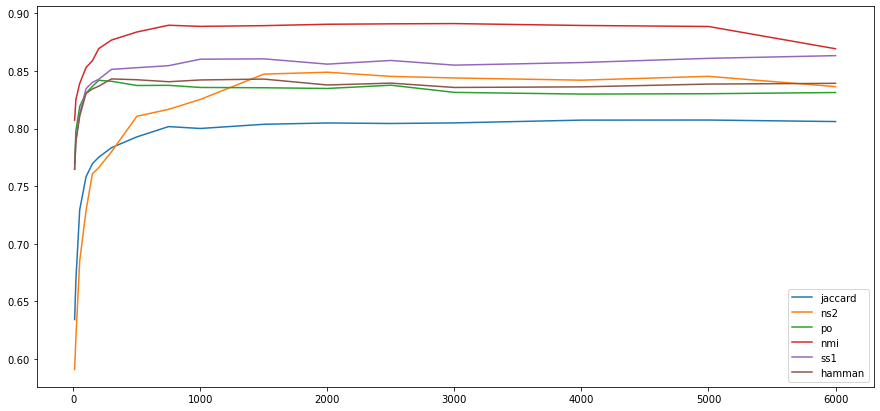

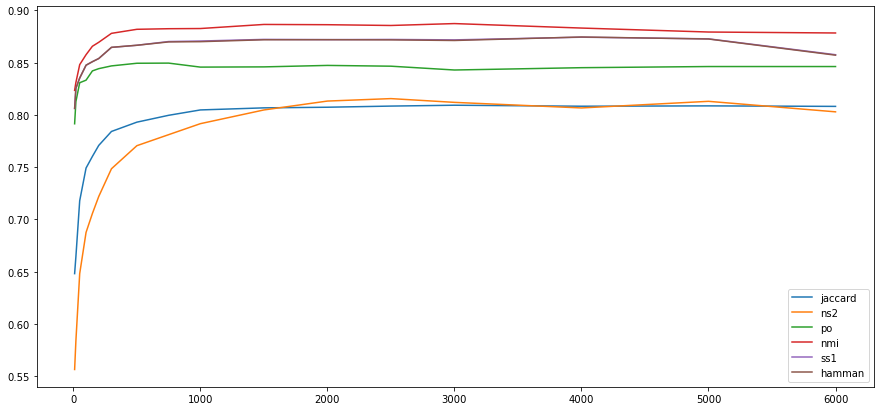

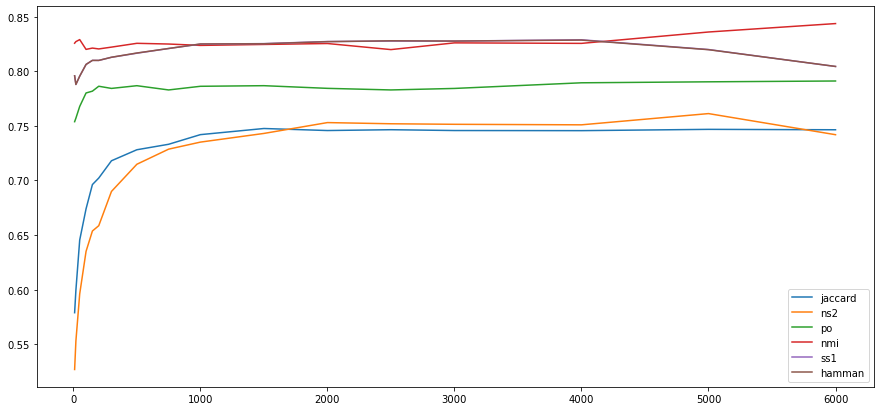

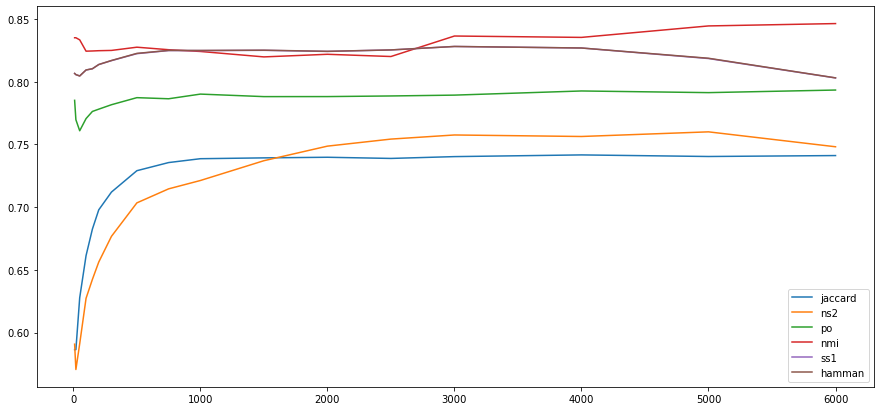

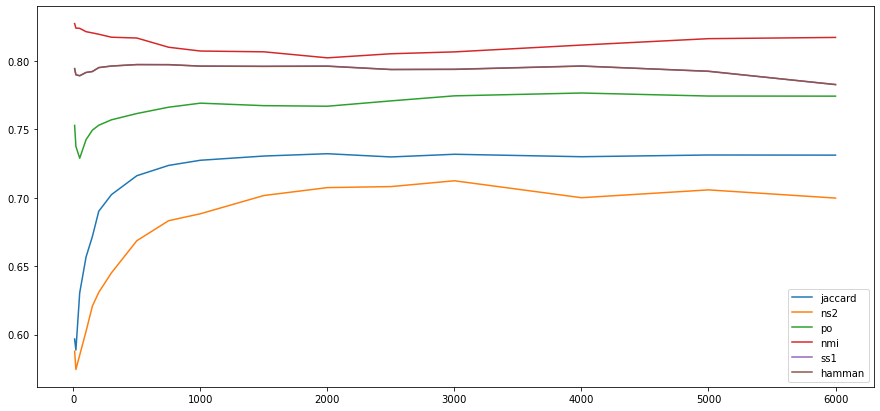

In [20]:
for index, avg_prediction_results in enumerate(all_sets_avg_results):
    draw_chart(avg_prediction_results)

# Build Single Profile

In [24]:
categories = ['sci.space', 'comp.graphics', 'talk.politics.misc', 'rec.sport.hockey', 'comp.sys.mac.hardware', 'sci.crypt', 'sci.electronics', 'sci.med','soc.religion.christian','comp.os.ms-windows.misc', 'misc.forsale',] 
categories = categories[:2]
rand_int = randint(10, 99)

remove = ('headers', 'footers', 'quotes')
data_set = fetch_20newsgroups(subset='all', shuffle=True, random_state=rand_int, categories = categories, remove = remove)

all_documents = list(zip(data_set.data, data_set.target))
train = all_documents[:int(len(all_documents)*0.75)]
test = all_documents
for doc in train:
    test.remove(doc)
print(f'-------SPLIT DONE-------')
real_vectorised_documents, real_words_list = vectorised_docs_words_list(documents=train)
print(f'-------VECTORISATION DONE-------')
real_words_list_count = calculate_documents(vectorised_documents=real_vectorised_documents, words_list=real_words_list)
real_total_docs_count = calculatet_total_docs_count(documents=train)
print(f'-------DOCS CALSULATIONS DONE-------')
# Train 

real_classes = [i for i, p_class in enumerate(data_set.target_names)]
real_words_list_abcd = calculate_a_b_c_d(classes=real_classes, words_list_count=real_words_list_count, total_docs_count=real_total_docs_count)
print(f'-------ABCD CALSULATION DONE-------')

prdict_functions = [(jaccard, True), (ns2, False), (po,True), (nmi,True), (ss1, True), (hamman, True)]
#     prdict_functions = [(jaccard, True), (ns2, False)]
# profiles_lengths = [10, 20, 50, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000]
profiles_lengths = [10]

real_profiles = mass_profiles_build(prdict_functions=prdict_functions, profiles_lengths=profiles_lengths, classes=real_classes, words_list_abcd=real_words_list_abcd)
print(f'-------PROFILES BUILD DONE-------')

-------SPLIT DONE-------
-------VECTORISATION DONE-------
-------DOCS CALSULATIONS DONE-------
-------ABCD CALSULATION DONE-------
-------PROFILES BUILD DONE-------


In [38]:
for key, value in real_profiles.items():
#     print(key)
    for subkey, subvalue in value.items():
        print(subkey)
        for subsubkey, subsubvalue in subvalue.items():
#             print(subsubkey)
            if subsubkey == 0:
                pprint(subsubvalue)

jaccard_10
{'does': 0.17654171704957677,
 'file': 0.14343163538873996,
 'graphics': 0.2472972972972973,
 'image': 0.15151515151515152,
 'know': 0.20477815699658702,
 'like': 0.18469945355191256,
 'need': 0.15233415233415235,
 'program': 0.15365853658536585,
 'thanks': 0.20747422680412372,
 'use': 0.1623222748815166}
ns2_10
{'does': 0.8234582829504232,
 'file': 0.8565683646112601,
 'graphics': 0.7527027027027027,
 'image': 0.8484848484848485,
 'know': 0.7952218430034129,
 'like': 0.8153005464480875,
 'need': 0.8476658476658476,
 'program': 0.8463414634146341,
 'thanks': 0.7925257731958762,
 'use': 0.8376777251184834}
po_10
{'code': 0.19823821702912275,
 'computer': 0.19795105901948415,
 'file': 0.24648374772277604,
 'files': 0.22303262544216268,
 'format': 0.20222184857006975,
 'graphics': 0.36729267183043396,
 'image': 0.21675286003969238,
 'thanks': 0.24099217717696728,
 'video': 0.19277068400667835,
 'windows': 0.21004338218874824}
nmi_10
{'animation': 0.1967693425157008,
 'file': 0.

# TRY THIS

In [ ]:
avg_test_results = pipline_calculation(3)

In [1]:
draw_chart(avg_test_results)

NameError: name 'draw_chart' is not defined

In [78]:
print(all_sets_avg_results[0])

{'jaccard': {'jaccard_10': [0.6312594291731891, 0.6023391812865497, 0.6081199090966639, datetime.timedelta(seconds=1, microseconds=41365)], 'jaccard_20': [0.6725039491078297, 0.6494152046783624, 0.6587694569440414, datetime.timedelta(seconds=1, microseconds=17823)], 'jaccard_50': [0.7356556840325557, 0.7154970760233919, 0.7258072676138577, datetime.timedelta(seconds=1, microseconds=15321)], 'jaccard_100': [0.7572996908320008, 0.7321637426900585, 0.7450707624649101, datetime.timedelta(seconds=1, microseconds=27600)], 'jaccard_150': [0.7652836831356976, 0.7350877192982457, 0.749662372250697, datetime.timedelta(seconds=1, microseconds=16227)], 'jaccard_200': [0.773306544049935, 0.7383040935672516, 0.7539229192266093, datetime.timedelta(seconds=1, microseconds=19036)], 'jaccard_300': [0.7818161906929837, 0.7435672514619882, 0.7597305561448812, datetime.timedelta(seconds=1, microseconds=32927)], 'jaccard_500': [0.7883397942249333, 0.7494152046783625, 0.7657169012932264, datetime.timedelta(s

In [112]:
cols= [10, 20, 50, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000]
df = pd.read_csv('results0.txt', sep=";")

In [117]:
pd.set_option('display.max_colwidth', None)

# Print prdictions results as a table

In [166]:
# 3 classes
df = pd.read_csv('results'+str(0)+'.txt', sep=";")
pd.concat([df.iloc[:,0:2],df.iloc[:,7:9],df.iloc[:,-3:-1]],axis = 1)

,profile,10,300,500,5000,6000
0,jaccard,"['0.6312594291731891', '0.6023391812865497', '0.6081199090966639', '0:00:01.041365']","['0.7818161906929837', '0.7435672514619882', '0.7597305561448812', '0:00:01.032927']","['0.7883397942249333', '0.7494152046783625', '0.7657169012932264', '0:00:01.026846']","['0.7998234479131557', '0.7532163742690059', '0.7708411217356123', '0:00:01.085774']","['0.7987514568897148', '0.7511695906432749', '0.7689925616191502', '0:00:01.247014']"
1,ns2,"['0.5897566338484038', '0.5847953216374269', '0.5742639119040999', '0:00:01.023313']","['0.7863959433924604', '0.786842105263158', '0.7873146306578744', '0:00:01.041603']","['0.8164428970201106', '0.815204678362573', '0.8166086365136245', '0:00:01.028120']","['0.841759501966826', '0.8415204678362572', '0.8454159247864222', '0:00:01.058208']","['0.8400643255570139', '0.8406432748538013', '0.8447420839239197', '0:00:01.056245']"
2,po,"['0.7699150247823756', '0.7058479532163743', '0.6997210099587445', '0:00:01.014816']","['0.8423795453365652', '0.8292397660818713', '0.838205962201102', '0:00:01.038870']","['0.8376526085233872', '0.8213450292397662', '0.8323116948417049', '0:00:01.057088']","['0.8274538822909218', '0.7874269005847954', '0.803314307901038', '0:00:01.056617']","['0.8273062338727761', '0.7874269005847954', '0.8033462921576765', '0:00:01.049981']"
3,nmi,"['0.8072141072472385', '0.6716374269005848', '0.6515560851000154', '0:00:01.104563']","['0.8727714993478962', '0.8567251461988304', '0.8588679970722426', '0:00:01.013371']","['0.8826036651048831', '0.8698830409356726', '0.8727033416824286', '0:00:01.030813']","['0.8921349461937729', '0.8883040935672515', '0.8931470474916011', '0:00:01.024365']","['0.8837569064986888', '0.87953216374269', '0.8854488125375399', '0:00:01.047306']"
4,ss1,"['0.7582026740271925', '0.6973684210526316', '0.6930335203606763', '0:00:01.022670']","['0.8468886713229328', '0.8345029239766081', '0.8422103315588026', '0:00:01.014344']","['0.8515732284815565', '0.839766081871345', '0.8482686892163873', '0:00:01.033172']","['0.8590379226937795', '0.8488304093567252', '0.8587224021400524', '0:00:01.035888']","['0.8611274022550546', '0.8514619883040936', '0.8612162154123457', '0:00:01.025340']"
5,hamman,"['0.7582026740271925', '0.6973684210526316', '0.6930335203606763', '0:00:01.024207']","['0.8370602965613511', '0.8213450292397662', '0.830445784167847', '0:00:01.021392']","['0.840307281852183', '0.8239766081871345', '0.8339950650058879', '0:00:01.016179']","['0.8320136581618565', '0.8052631578947368', '0.8192676088085659', '0:00:01.048394']","['0.8335094139943356', '0.8070175438596492', '0.8208784503574759', '0:00:01.026688']"


In [167]:
# 5 classes
df = pd.read_csv('results'+str(1)+'.txt', sep=";")
pd.concat([df.iloc[:,0:2],df.iloc[:,7:9],df.iloc[:,-3:-1]],axis = 1)

,profile,10,300,500,5000,6000
0,jaccard,"['0.6481843596204545', '0.590468085106383', '0.5923443122446961', '0:00:01.549702']","['0.7856603309871265', '0.7446808510638299', '0.7503476209970531', '0:00:01.558589']","['0.7973397326580602', '0.7521702127659575', '0.7586999389104598', '0:00:01.551269']","['0.8060999593433852', '0.7477446808510637', '0.7552656622841095', '0:00:01.596722']","['0.8061872156474357', '0.7462127659574468', '0.7538097385100005', '0:00:01.631440']"
1,ns2,"['0.5553415567917804', '0.5019574468085106', '0.5019746691424695', '0:00:01.542080']","['0.7517622500549942', '0.745872340425532', '0.7461532255612743', '0:00:01.576188']","['0.7755788162249726', '0.7700425531914894', '0.7707785251450495', '0:00:01.563934']","['0.8027716779963953', '0.7986382978723404', '0.7996357679101943', '0:00:01.614053']","['0.7904618410317414', '0.7858723404255319', '0.7867681116627498', '0:00:01.600110']"
2,po,"['0.7866321581254148', '0.6827234042553192', '0.6792239807766312', '0:00:01.525702']","['0.8462694018264363', '0.8330212765957447', '0.8352749498626325', '0:00:01.620739']","['0.8484053488702443', '0.8314893617021278', '0.8344638173242902', '0:00:01.569622']","['0.8432118212835007', '0.8124255319148936', '0.817770564969992', '0:00:01.564280']","['0.8428936736700166', '0.8108936170212765', '0.8163349777530019', '0:00:01.586739']"
3,nmi,"['0.8218889778324729', '0.6522553191489362', '0.6419395646601107', '0:00:01.546449']","['0.8714796315484575', '0.8374468085106382', '0.8363816402098914', '0:00:01.541022']","['0.8761811706229606', '0.8481702127659574', '0.8477524730782223', '0:00:01.536769']","['0.8698673852581267', '0.8657021276595745', '0.8674807569548653', '0:00:01.548111']","['0.8748296032477771', '0.8665531914893616', '0.8693338257657267', '0:00:01.579098']"
4,ss1,"['0.8002531871947284', '0.6699574468085107', '0.6636046875230426', '0:00:01.535243']","['0.8602515871308789', '0.8411914893617022', '0.8416818709514342', '0:00:01.549178']","['0.866445217753918', '0.8507234042553191', '0.8518981963599666', '0:00:01.553883']","['0.8672946223324756', '0.8622978723404253', '0.8638533121052886', '0:00:01.553395']","['0.8460387441766184', '0.8306382978723403', '0.8322898378695978', '0:00:01.575642']"
5,hamman,"['0.8002531871947284', '0.6699574468085107', '0.6636046875230426', '0:00:01.527410']","['0.8602515871308789', '0.8411914893617022', '0.8416818709514342', '0:00:01.571572']","['0.8661375475538', '0.8503829787234043', '0.8515776835394538', '0:00:01.528431']","['0.8662283627567632', '0.8611063829787234', '0.8627181359791137', '0:00:01.583617']","['0.8457322369326284', '0.8306382978723403', '0.8325318680574055', '0:00:01.575021']"


In [168]:
# 7 classes
df = pd.read_csv('results'+str(2)+'.txt', sep=";")
pd.concat([df.iloc[:,0:2],df.iloc[:,7:9],df.iloc[:,-3:-1]],axis = 1)

,profile,10,300,500,5000,6000
0,jaccard,"['0.5762245179737043', '0.5267386091127098', '0.5267174179411459', '0:00:02.068208']","['0.7207281078650556', '0.6465227817745803', '0.6486773444410382', '0:00:02.074561']","['0.7352611118919915', '0.6526378896882494', '0.6553431137998603', '0:00:02.075271']","['0.7475458128397052', '0.6486810551558753', '0.6527794820424734', '0:00:02.162110']","['0.7471988591141733', '0.6476019184652279', '0.6517624356280068', '0:00:02.163422']"
1,ns2,"['0.5420964687950839', '0.3984412470023981', '0.3972679031318949', '0:00:02.051933']","['0.6798077305958837', '0.6679856115107914', '0.6676333501372058', '0:00:02.078168']","['0.714684376442374', '0.7040767386091127', '0.7044125560814484', '0:00:02.103453']","['0.7639403575720736', '0.7591127098321343', '0.7586755224172185', '0:00:02.141326']","['0.7538374421112545', '0.7486810551558752', '0.7485792713613041', '0:00:02.131183']"
2,po,"['0.7512276200568826', '0.5974820143884891', '0.5940681296548364', '0:00:02.092110']","['0.793823064200333', '0.7643884892086331', '0.7657881853136013', '0:00:02.074007']","['0.7917324825147295', '0.76378896882494', '0.7654235933263935', '0:00:02.067431']","['0.7918969484366343', '0.7587529976019184', '0.7622198612521495', '0:00:02.107869']","['0.7894728331401488', '0.7488009592326139', '0.75276219916502', '0:00:02.122068']"
3,nmi,"['0.8164979596523588', '0.5515587529976019', '0.542803164850592', '0:00:02.057873']","['0.8192051939684228', '0.7434052757793765', '0.7403545211302982', '0:00:02.055903']","['0.8229465324053828', '0.763189448441247', '0.7607377065960941', '0:00:02.061649']","['0.8375154196116716', '0.8287769784172662', '0.8303108651012788', '0:00:02.090655']","['0.847080944081061', '0.8401678657074341', '0.8410011731264178', '0:00:02.111070']"
4,ss1,"['0.7916608054154443', '0.5826139088729017', '0.5766029342126557', '0:00:02.074270']","['0.8157034701778813', '0.7809352517985612', '0.7809507934901887', '0:00:02.070302']","['0.818642141325481', '0.791726618705036', '0.7916029319228647', '0:00:02.066756']","['0.8206014819114997', '0.7994004796163069', '0.7998789797563146', '0:00:02.072970']","['0.8038831107200102', '0.7372901678657074', '0.7380375239972528', '0:00:02.062475']"
5,hamman,"['0.7916608054154443', '0.5826139088729017', '0.5766029342126557', '0:00:02.051345']","['0.8157034701778813', '0.7809352517985612', '0.7809507934901887', '0:00:02.094928']","['0.8187592648868703', '0.7918465227817746', '0.7917333950670263', '0:00:02.074365']","['0.8205569435643996', '0.799400479616307', '0.7998808838517859', '0:00:02.122409']","['0.8039980744655623', '0.7381294964028776', '0.7391222539851326', '0:00:02.151361']"


In [169]:
# 9 classes
df = pd.read_csv('results'+str(3)+'.txt', sep=";")
pd.concat([df.iloc[:,0:2],df.iloc[:,7:9],df.iloc[:,-3:-1]],axis = 1)

,profile,10,300,500,5000,6000
0,jaccard,"['0.5938499379007208', '0.5429099307159353', '0.5407106918577979', '0:00:02.690868']","['0.7157537202238438', '0.5890993071593533', '0.5830095710427672', '0:00:02.682683']","['0.727552101522407', '0.5936258660508084', '0.5880247382368877', '0:00:02.758522']","['0.7400830502035538', '0.5873441108545034', '0.5826843093564288', '0:00:02.834130']","['0.7408457105326702', '0.5879907621247114', '0.5834289717709925', '0:00:02.853151']"
1,ns2,"['0.5883256992274235', '0.41117782909930717', '0.41429946584353206', '0:00:02.720868']","['0.6809801856010098', '0.66540415704388', '0.6653611836454384', '0:00:02.708030']","['0.7038247022873464', '0.6931177829099308', '0.6926545198301962', '0:00:02.722979']","['0.7547402629217641', '0.7490069284064667', '0.7492326670122003', '0:00:02.868779']","['0.7443637668687679', '0.734041570438799', '0.734053970903235', '0:00:02.875712']"
2,po,"['0.782043610281415', '0.5824480369515012', '0.5758888065644736', '0:00:02.680802']","['0.7828163135663682', '0.7297921478060045', '0.7254842546120289', '0:00:02.696313']","['0.7914204961722136', '0.7347806004618938', '0.7303280070605165', '0:00:02.663180']","['0.7967109162935753', '0.7160277136258661', '0.713364744936789', '0:00:02.730755']","['0.7968064054211434', '0.7205542725173211', '0.7183107621113467', '0:00:02.767631']"
3,nmi,"['0.8324750771793038', '0.5289607390300232', '0.5190507607631212', '0:00:02.667382']","['0.8245348056558857', '0.7377367205542724', '0.7306862371967592', '0:00:02.657091']","['0.8256283145866018', '0.7575981524249422', '0.7519828519920118', '0:00:02.657954']","['0.8469303401664898', '0.8384295612009238', '0.8386965595174309', '0:00:02.701799']","['0.8466628742555417', '0.8367667436489608', '0.8360800233421136', '0:00:02.750999']"
4,ss1,"['0.800311017802963', '0.5769976905311778', '0.569843173902177', '0:00:02.661002']","['0.820833591758958', '0.7750577367205542', '0.7721682827681122', '0:00:02.684319']","['0.8216009524739112', '0.7846651270207852', '0.7822928722596793', '0:00:02.673873']","['0.8168842460635848', '0.7769976905311778', '0.7759830324954506', '0:00:02.713438']","['0.7925575119581192', '0.6604157043879908', '0.6590230411897704', '0:00:02.750729']"
5,hamman,"['0.800311017802963', '0.5769976905311778', '0.569843173902177', '0:00:02.665664']","['0.8207364512130096', '0.7749653579676673', '0.7720733160064788', '0:00:02.696691']","['0.8217056786462973', '0.784757505773672', '0.7823824016932901', '0:00:02.691024']","['0.8167770907560975', '0.776905311778291', '0.7758937866230722', '0:00:02.719590']","['0.7931109517059011', '0.6612471131639722', '0.6599697869694261', '0:00:02.726047']"


In [170]:
# 11 classes
df = pd.read_csv('results'+str(4)+'.txt', sep=";")
pd.concat([df.iloc[:,0:2],df.iloc[:,7:9],df.iloc[:,-3:-1]],axis = 1)

,profile,10,300,500,5000,6000
0,jaccard,"['0.5932380663838278', '0.5387570621468927', '0.5359468771055156', '0:00:03.603870']","['0.7082473473338796', '0.5954048964218457', '0.5902117541348492', '0:00:03.632618']","['0.7193211265129941', '0.5958568738229756', '0.5909544220239169', '0:00:03.636299']","['0.737903856013389', '0.5896045197740113', '0.585402941979098', '0:00:03.888075']","['0.7364902376868073', '0.5888512241054613', '0.5846137017199509', '0:00:03.856213']"
1,ns2,"['0.5925654214988733', '0.42629001883239165', '0.42746192936088845', '0:00:03.556539']","['0.6573736739891527', '0.6378154425612053', '0.6373621105875477', '0:00:03.619953']","['0.6763311412669007', '0.6602636534839925', '0.6600671224030965', '0:00:03.628679']","['0.7023928840868465', '0.6806779661016948', '0.6838833297021492', '0:00:03.797410']","['0.6954739496573458', '0.6772128060263654', '0.6798598578461237', '0:00:03.840808']"
2,po,"['0.7435958948898678', '0.5673069679849341', '0.5631501380052307', '0:00:03.544362']","['0.7583451575154244', '0.7087758945386063', '0.7056392203451028', '0:00:03.636183']","['0.7646117814202584', '0.7095291902071563', '0.706766805428561', '0:00:03.578941']","['0.7815766737231664', '0.6983050847457627', '0.6966179244019062', '0:00:03.686337']","['0.7800245340357594', '0.704105461393597', '0.7028376805474524', '0:00:03.689889']"
3,nmi,"['0.824170873347551', '0.4948399246704332', '0.48806244010237715', '0:00:03.546797']","['0.8092652191667445', '0.6909227871939736', '0.6859091727059866', '0:00:03.535178']","['0.8076060959954429', '0.7095291902071563', '0.7056383420519504', '0:00:03.549527']","['0.8170288320290536', '0.8006026365348399', '0.802466827867405', '0:00:03.619749']","['0.8147146624345627', '0.7923917137476459', '0.7941022750466102', '0:00:03.670712']"
4,ss1,"['0.7870201883009533', '0.5550282485875705', '0.5500049866609997', '0:00:03.547975']","['0.7978885893319547', '0.7414689265536724', '0.7390628557494503', '0:00:03.559249']","['0.8016014166645699', '0.7552542372881356', '0.7527914329460197', '0:00:03.553924']","['0.7937989412271784', '0.744406779661017', '0.745745676953448', '0:00:03.604413']","['0.7877005336483837', '0.6627495291902072', '0.6648010388435284', '0:00:03.622248']"
5,hamman,"['0.7870201883009533', '0.5550282485875705', '0.5500049866609997', '0:00:03.550746']","['0.7978885893319547', '0.7414689265536724', '0.7390628557494503', '0:00:03.562057']","['0.8015325307006295', '0.7551789077212805', '0.7527178223460933', '0:00:03.551721']","['0.7937989412271784', '0.744406779661017', '0.745745676953448', '0:00:03.603364']","['0.7879012600929448', '0.6632768361581921', '0.6654336634363126', '0:00:03.588975']"


# Create dataframes from all_sets_avg_results

In [111]:
# create tables profiles - lengths - cells = accuracy ... data
    for index,dataset in enumerate(all_sets_avg_results):
        with open ('results'+str(index)+'.txt', 'w') as file:
            file.write('profile;'+'10;'+'20;'+'50;'+'100;'+'150;'+'200;'+'300;'+'500;'+'750;'+'1000;'+ '1500;'+ '2000;'+ '2500;'+'3000;'+ '4000;'+ '5000;'+ '6000;'+'\n')
            for profile, profile_data in dataset.items():
                new_string = []
                new_string.append(profile)
                for subprofile, data in profile_data.items():
                    data_str = []
                    for i in data:
                        data_str.append(str(i))
                    new_string.append(data_str)
                for j in new_string:
                    file.write(str(j)+';')
                file.write('\n') 
            file.write('\n') 

In [216]:
categories = ['sci.space', 'comp.graphics', 'talk.politics.misc', 'rec.sport.hockey', 'comp.sys.mac.hardware', 'sci.crypt', 'sci.electronics', 'sci.med','soc.religion.christian','comp.os.ms-windows.misc', 'misc.forsale',] 
# categories = categories[:2]
rand_int = randint(10, 99)

remove = ('headers', 'footers', 'quotes')
data_set = fetch_20newsgroups(subset='all', shuffle=True, random_state=rand_int, categories = categories, remove = remove)

all_documents = list(zip(data_set.data, data_set.target))

In [217]:
data_set.target_names

['comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.mac.hardware',
 'misc.forsale',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.misc']

In [221]:
classes = {}
for doc in all_documents:
#     print(doc[1])
    if doc[1] in classes:
        classes[doc[1]] +=1
    else:
        classes[doc[1]] =1

In [222]:
len(all_documents)

10619

In [223]:
classes

{8: 987,
 1: 985,
 3: 975,
 7: 990,
 6: 984,
 4: 999,
 2: 963,
 5: 991,
 9: 997,
 0: 973,
 10: 775}

In [225]:
categories = ['sci.space', 'comp.graphics', 'talk.politics.misc', 'rec.sport.hockey', 'comp.sys.mac.hardware', 'sci.crypt', 'sci.electronics', 'sci.med','soc.religion.christian','comp.os.ms-windows.misc', 'misc.forsale',] 
categories = categories[:2]
rand_int = randint(10, 99)

remove = ('headers', 'footers', 'quotes')
data_set = fetch_20newsgroups(subset='all', shuffle=True, random_state=rand_int, categories = categories, remove = remove)

all_documents = list(zip(data_set.data, data_set.target))
train = all_documents[:int(len(all_documents)*0.75)]
test = all_documents
for doc in train:
    test.remove(doc)
print(f'-------SPLIT DONE-------')
real_vectorised_documents, real_words_list = vectorised_docs_words_list(documents=train)
print(f'-------VECTORISATION DONE-------')

-------SPLIT DONE-------
-------VECTORISATION DONE-------


In [226]:
len(real_words_list)

21106